### A plot of $Z_\star - M_\star$ relation

In [1]:
# setup notebook for inline figures
%matplotlib inline
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from code.plot_utils import plot_pretty
plot_pretty()

Data files required for script plotting $Z_\star-M_\star$ relation of galaxies can be found <a href="http://astro.uchicago.edu/~andrey/classes/a304s18/data/">here</a>

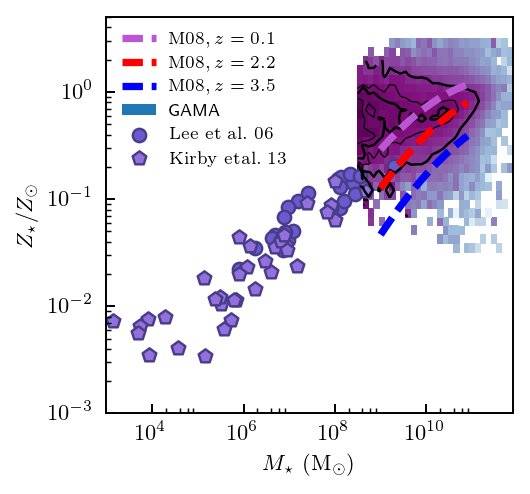

In [6]:
from code.setup.setup import data_home_dir


fig = plt.figure(figsize=(3, 3))
ylabel = r'$Z_\star/Z_\odot$'; xlabel = r'$M_{\star}\ \rm (M_\odot)$'
xlims = [1.e3, 8.e11]; ylims = [1.e-3,  5.]
plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.xscale('log'); plt.yscale('log')
plt.xlim(xlims); plt.ylim(ylims)

#
# plot observational trend from Maiolino
OHsol = 9.
    
def Zmaiolino08(lMs,lM0,K0):
    """
    best fit relation from table in Maiolino et al. 2008 using consistent Z calibration
    """
    return -0.0864*(lMs-lM0)**2 + K0

zcolors = ['mediumorchid', 'red', 'blue', 'darkgray']
zmaio = np.array([0.07,  2.2, 3.5])
lM0 = np.array([11.8, 12.38, 12.76])
K0 = np.array([9.04, 8.99, 8.79])
nzplot = 3

lMs = np.arange(9.0, 11.0, 0.1)
for i, zm in enumerate(zmaio[:nzplot]): 
    Zmaio = Zmaiolino08(lMs, lM0[i], K0[i]) - OHsol + 0.1
    plt.plot(10.**lMs, 10.**Zmaio, '--', c=zcolors[i], lw=3.0, label=r'${\rm M08}, z=%.1f$'%zm)

#
# plot GAMA data
#

def compute_inverse_Vmax(mags, zs, m_min=None, m_max=None, cosmomodel='WMAP9'):
    """compute inverse Vmax for a given set of galaxy magnitudes and redshifts, given magnitude limits m_min and m_max"""
    #from code.calc_kcor import calc_kcor 
    #ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
    #kcorr = calc_kcor('r', zk, 'g - r', grm)
    from colossus.cosmology import cosmology
    # set cosmology to the best values from 9-year WMAP data
    cosmo = cosmology.setCosmology(cosmomodel)

    # compute luminosity and angular distances
    d_L = cosmo.luminosityDistance(zs)/cosmo.h

    # absolute magnitude in the r-band corrected for extinction
    Mabs = mags - 5.0*np.log10(d_L/1e-5) #- extm + 1.3*zs - kcorr; 

    # the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
    # we need to compute at what distance this galaxy would have limiting magnitude mlim, 
    # then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
    d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mabs))/(1.+zs)
    d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mabs))/(1.+zs)

    vmaxi = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))
    return vmaxi


def plot_GAMA():
    def read_GAMA(fname):
        import pyfits
        hdulist = pyfits.open(fname)
        return np.asarray(hdulist[1].data)
    
    data = read_GAMA(data_home_dir()+"GAMA_DR2_full.fits")
 
    z_min = 0.001
    z_max = 0.3
    m_min = 10.5
    m_max = 19.0
 
    data = data[data['GAL_MAG_R'] < m_max]; 
    data = data[data['GAL_MAG_R'] > m_min]; 
    data = data[data['Z_HELIO'] > z_min];   
    data = data[data['Z_HELIO'] < z_max]
 
    vmaxi = compute_inverse_Vmax(data['GAL_MAG_R'], data['Z_HELIO'], m_min, m_max)
    vmaxnorm = np.sum(vmaxi)
    vmaxi /= vmaxnorm
    Z = data['metal']/0.018 # normalize to solar according to Asplund et al. (2004)
    lZ = np.log10(Z)
    lMstar = data['logmstar']
    Mstar = np.power(10.,lMstar)
    clevs = np.linspace(0.2,0.95,4)
    
    import scipy.optimize as opt
    from matplotlib.colors import LogNorm
 
    def conf_interval(x, pdf, conf_level):
        return np.sum(pdf[pdf > x])-conf_level
 
    #
    H, xbins, ybins = np.histogram2d(lMstar, lZ, weights=vmaxi, bins=(np.linspace(8.5, 12., 31), np.linspace(-1.5, 1.0, 31)))
 
    H = np.rot90(H)
    H = np.flipud(H)
    Hmask = np.ma.masked_where(H==0,H)
    H = H/np.sum(H)        
             
    xbins = 10.**xbins; ybins = 10.**ybins
    X,Y = np.meshgrid(xbins[:-1],ybins[:-1]) 
 
    clevs = np.linspace(0.2,0.95,4)
    lvls = []
    for cld in clevs:  
        sig = opt.brentq( conf_interval, 0., 1., args=(H,cld) )  
        lvls.append(sig)
        
    #plt.scatter(10.**lMstar, 10.**lZ, c='m', s=0.85, alpha=0.5)
    plt.pcolor(X,Y,(Hmask),cmap=plt.cm.BuPu, norm = LogNorm(), label='GAMA',rasterized=True)
    plt.contour(X,Y,(H), linewidths=(1.0,0.5), colors='black', levels = lvls[::-1], norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])


plot_GAMA()

# plot Lee et al. 2006
lMsL = np.linspace(5.5, 9.5, 100)
lZLp, elZLp, lMsLp = np.loadtxt(data_home_dir()+"lee06.txt",usecols=(1,3,4),unpack=True)
lZLp = lZLp - OHsol
plt.scatter(10**lMsLp,10.**lZLp, s=30, marker='o', c='slateblue',
            edgecolor='darkslateblue', label=r'$\rm Lee\ et\ al.\ 06$')
lLVk, elLVk, lZk, elZk  = np.loadtxt(data_home_dir()+"kirby13_tab4.txt",usecols=(4,5,6,7),unpack=True)
plt.scatter(10**lLVk, 10.**lZk, s=35, marker='p', 
            c='mediumpurple', edgecolor='darkslateblue',
            label=r'$\rm Kirby\ et al.\ 13$')

plt.legend(frameon=False, loc='upper left', scatterpoints=1, fontsize=7)
#plt.grid()
#plt.savefig('fig/MsZ.pdf', bbox_inches='tight')
plt.show()


Below I include a script showing you how to access the metallicity, SFR, and stellar mass of galaxies in the GAMA survey, which can be used to plot the "fundamental relation" and compare to the model. You can either compare in 2D projections ($M_\star-Z$, $\dot{M}_\star-M_\star$) or plot predictions and observations in a 3D plot, using <a href="https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html">mplot3d</a> routines of matplotlib.

In [ ]:
from code.setup import data_home_dir

def read_GAMA(fname):
    import pyfits
    hdulist = pyfits.open(fname)
    return np.asarray(hdulist[1].data)
    
data = read_GAMA(data_home_dir()+"GAMA_DR2_full.fits")
 
z_min = 0.001
z_max = 0.3
m_min = 10.5
m_max = 19.0
 
data = data[data['GAL_MAG_R'] < m_max]; 
data = data[data['GAL_MAG_R'] > m_min]; 
data = data[data['Z_HELIO'] > z_min];   
data = data[data['Z_HELIO'] < z_max]
 
Z = data['metal']/0.018 # normalize to solar metallicity
lZ = np.log10(Z)
lMstar = data['logmstar']
Mstar = np.power(10.,lMstar)
sfr = data['SFR']; lsfr = np.log10(sfr)
